In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

import cv2
import gc
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from keras import layers


In [8]:
!pip install opendatasets
!pip install pandas

In [9]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")


Skipping, found downloaded files in "./lung-and-colon-cancer-histopathological-images" (use force=True to force download)


In [10]:
path = '/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes


['lung_n', 'lung_aca', 'lung_scc']

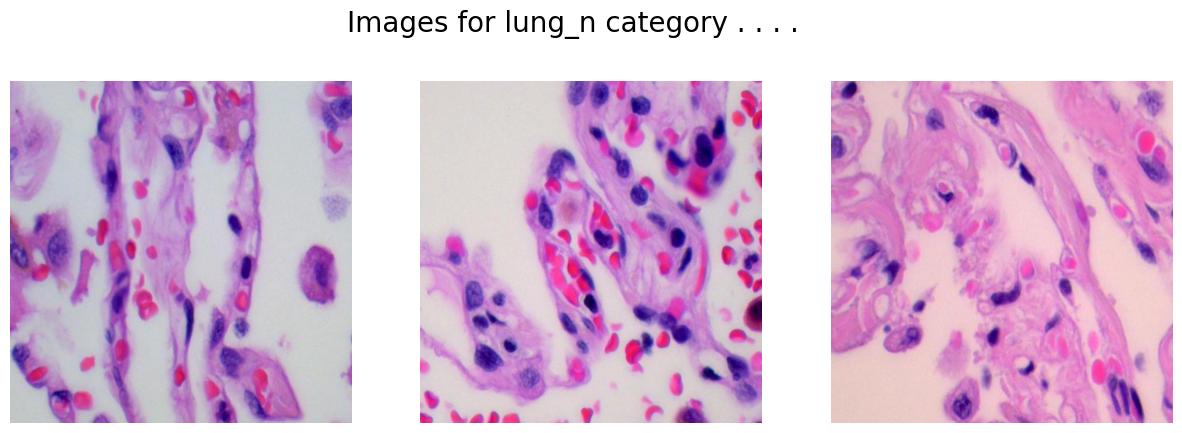

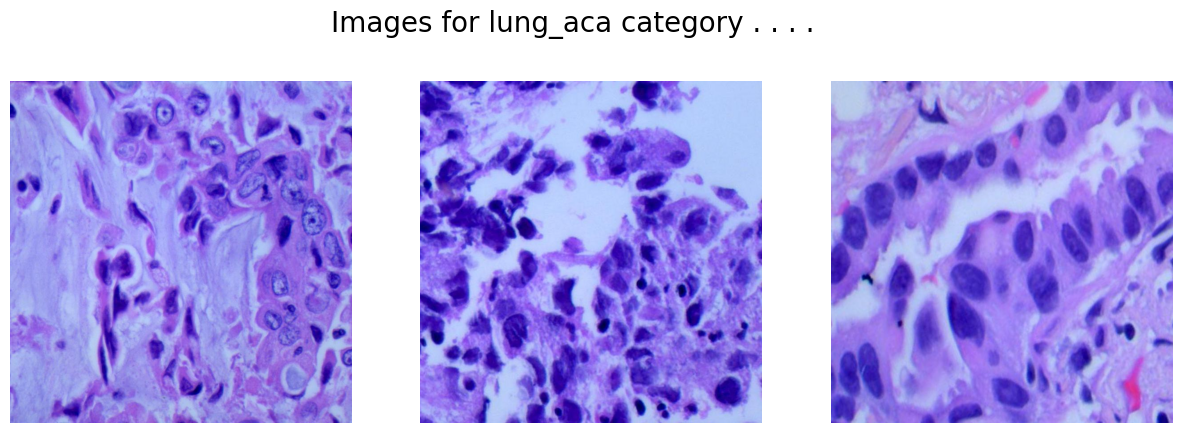

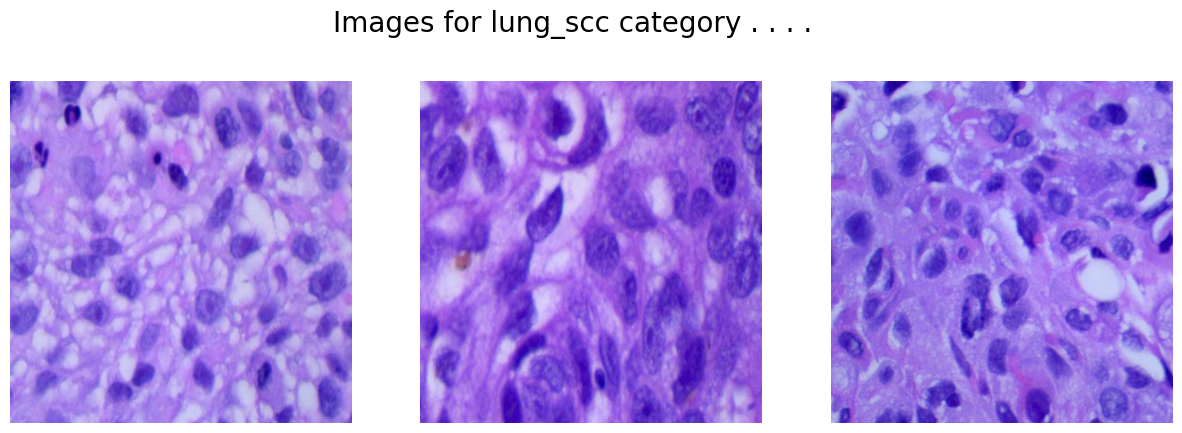

In [44]:
path = '/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [12]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_SIZE = 256
BATCH_SIZE = 64
path = '/content/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'


# ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Training dataset generator
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)


val_generator = train_datagen.flow_from_directory(
    path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)


Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Number of classes: 3


In [16]:
# Model architecture
model = keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),  # Increased dropout

    layers.Dense(3, activation='softmax')
])

# Show model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      33,554,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 33,685,059 (128.50 MB)

 Trainable params: 33,683,907 (128.49 MB)

 Non-trainable params: 1,152 (4.50 KB)

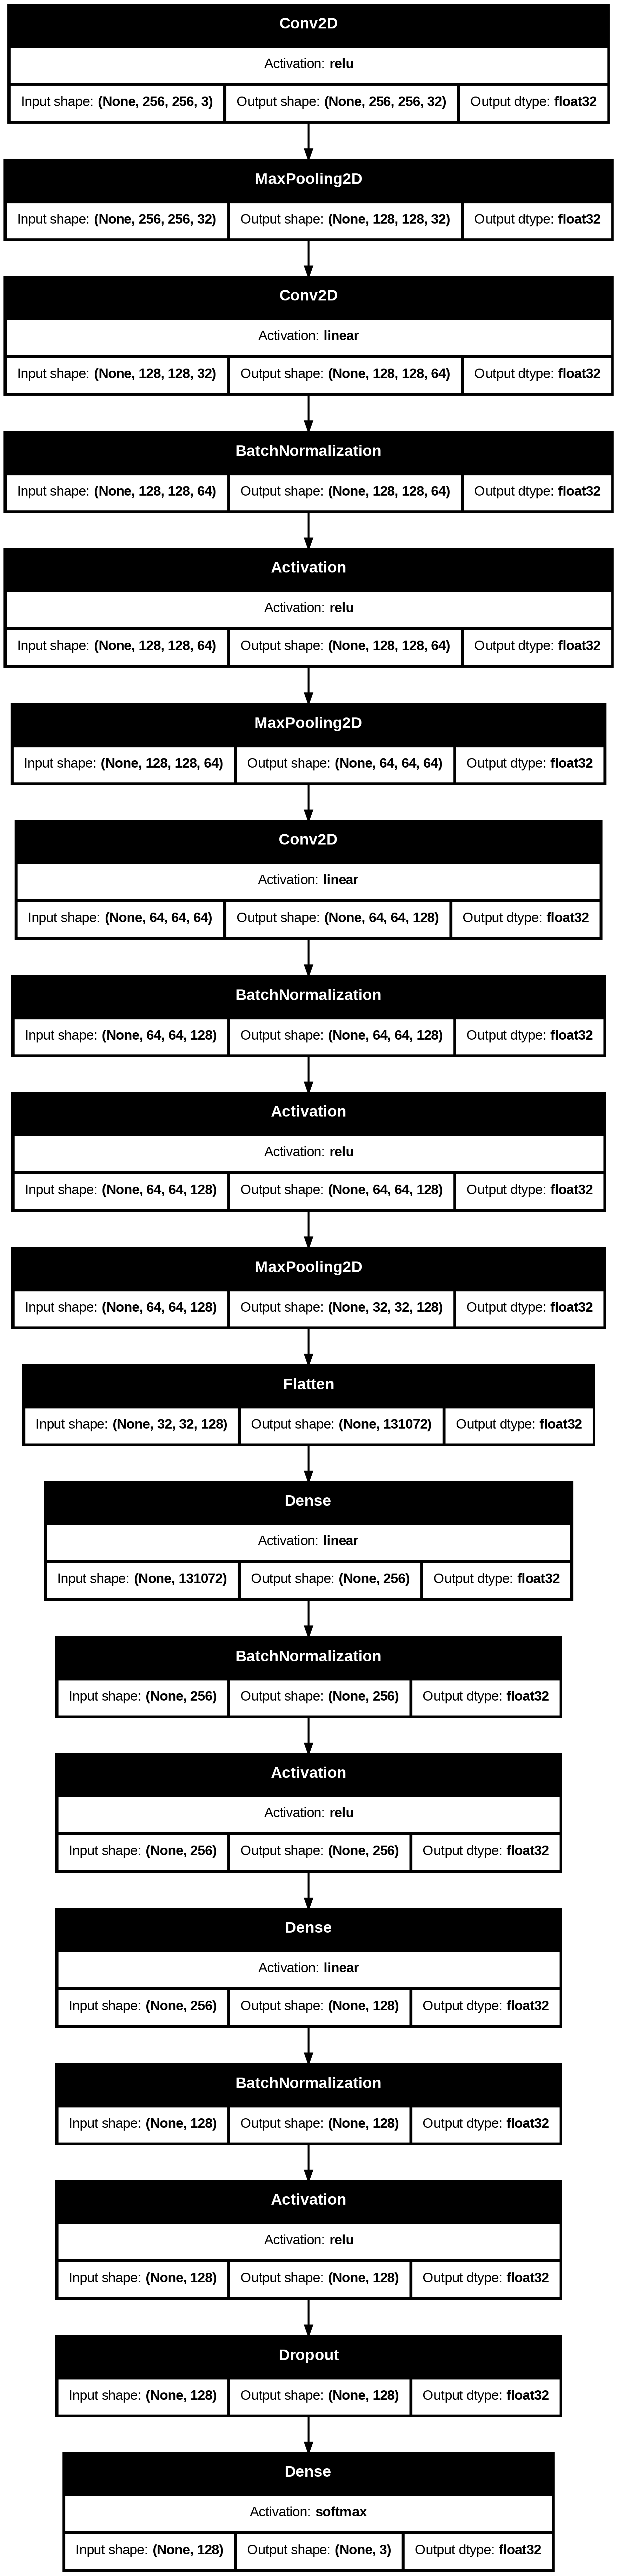

In [17]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



In [19]:

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy', 0) > 0.90:
            print("\nValidation accuracy reached 90%, stopping training.")
            self.model.stop_training = True

es = keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)


In [20]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
    callbacks=[es, lr, myCallback()]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 112s 503ms/step - accuracy: 0.8543 - loss: 0.3625 - val_accuracy: 0.3343 - val_loss: 3.2119 - learning_rate: 0.0010
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 391ms/step - accuracy: 0.9437 - loss: 0.1523 - val_accuracy: 0.5523 - val_loss: 2.2193 - learning_rate: 0.0010
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 390ms/step - accuracy: 0.9664 - loss: 0.0928 - val_accuracy: 0.8560 - val_loss: 0.3635 - learning_rate: 0.0010
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 80s 423ms/step - accuracy: 0.9834 - loss: 0.0531 - val_accuracy: 0.4883 - val_loss: 4.1126 - learning_rate: 0.0010
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9841 - loss: 0.0444
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 ━━━━━━━━━━━━━━━━━━━━ 75s 401ms/step - accuracy: 0.9841 - loss: 0.0444 - val_accuracy: 0.6233 - val_loss: 1.7895 - learning_rate: 0.0010
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.993

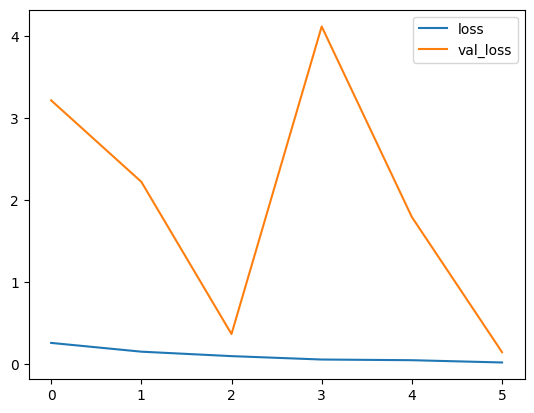

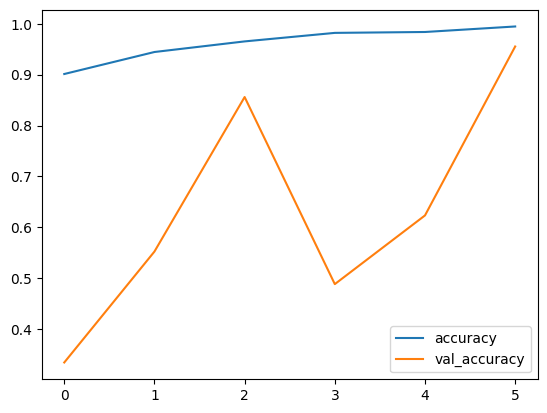

In [21]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 431ms/step


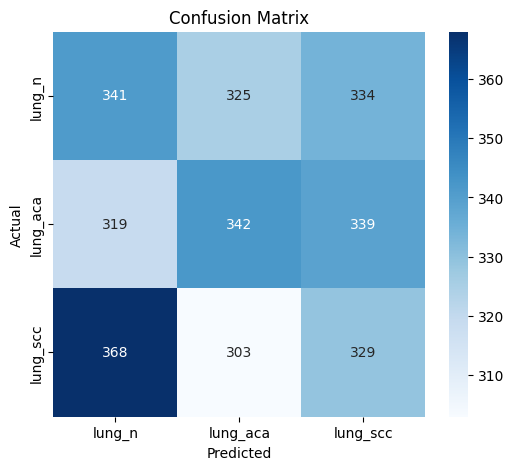

              precision    recall  f1-score   support

      lung_n       0.33      0.34      0.34      1000
    lung_aca       0.35      0.34      0.35      1000
    lung_scc       0.33      0.33      0.33      1000

    accuracy                           0.34      3000
   macro avg       0.34      0.34      0.34      3000
weighted avg       0.34      0.34      0.34      3000



In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


Y_pred = model.predict(val_generator)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = val_generator.classes


conf_matrix = confusion_matrix(Y_true, Y_pred_classes)


plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(Y_true, Y_pred_classes, target_names=classes))


## Checking the accuracy for a custom image from external resources


In [40]:
from google.colab import files
uploaded = files.upload()



Saving cancercellimsge.png to cancercellimsge (4).png


In [41]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

IMG_SIZE = 256


image_path = list(uploaded.keys())[0]
img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
img_array = image.img_to_array(img)


img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

print("Processed image shape:", img_array.shape)


Processed image shape: (1, 256, 256, 3)


In [42]:
# Get predictions
predictions = model.predict(img_array)

# Get class index with highest probability
predicted_class = np.argmax(predictions)

# Define class labels (match the original dataset order)
class_labels = classes  # Assuming "classes" contains your label names

print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Confidence: {np.max(predictions) * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Class: lung_aca
Confidence: 100.00%


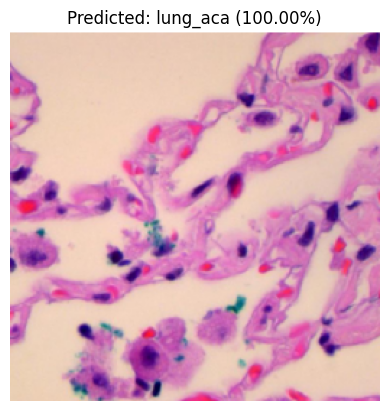

In [43]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {class_labels[predicted_class]} ({np.max(predictions) * 100:.2f}%)")
plt.show()
